In [1]:
! pip install yfinance
! pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 49.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peewee: filename=peewee-3.17.0-cp310-cp310-linux_x86_64.whl size=272541 sha256=a22ff6c50d5ed3edbae7a5950a296d0704d9ae065f52b381853bea07bc05fe18
  Stored in directory: /root/.cache/pip/wheels/c7/70/ad/212867e96e7004265a69c4aa5dcff00a95f547a67ba26e7e76
Successfully built peewee
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.1 MB/s eta 0:00:00


In [2]:
# Data preparation and PLotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from datetime import datetime
import seaborn as sns
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# Data reader
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

# Assign the yf's function to pandas_reader
yf.pdr_override()

# Statistic
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import statsmodels.api as smapi
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima.arima import auto_arima
import math

# Preprocessing and Machine Learning library
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import warnings
warnings.filterwarnings("ignore")

## GET DATA

In [4]:
# Get the stock data using pandas_datareader
# start_date = '2014-10-01'
# end_date = '2023-10-01'
end_date = datetime.now()
start_date = datetime(end_date.year - 15, end_date.month, end_date.day)

company_name = ['APPLE', 'GOOGLE', 'MICROSOFT', 'AMAZON']
stock_name = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
stock_data = {}

for i in range(len(stock_name)):
    stock_data[company_name[i]] = pdr.get_data_yahoo(stock_name[i], start = start_date, end = end_date)

# Get the Date list with type of datetime
date_time = stock_data['APPLE'].index

# Create another variable for each stock for further preprocessing and data cleansing
AAPL = stock_data['APPLE']
GOOG = stock_data['GOOGLE']
MSFT = stock_data['MICROSOFT']
AMZN = stock_data['AMAZON']
company_list = [AAPL, GOOG, MSFT, AMZN]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
AAPL.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-11-21,2.926071,3.004286,2.826429,2.949286,2.500051,1569271200
2008-11-24,3.043214,3.385357,3.030000,3.319643,2.813994,1442257600
2008-11-25,3.379643,3.382500,3.148571,3.242857,2.748905,1235292800
2008-11-26,3.211429,3.401786,3.208929,3.392857,2.876057,899836000
2008-11-28,3.382143,3.384286,3.280714,3.309643,2.805517,297774400
2008-12-01,3.260714,3.295357,3.175714,3.176071,2.692291,923767600
2008-12-02,3.215357,3.308929,3.089286,3.302500,2.799462,1148722400
2008-12-03,3.192857,3.436786,3.171429,3.425000,2.903304,1338680000
2008-12-04,3.372500,3.400357,3.180714,3.264643,2.767372,1091370000


In [6]:
AAPL.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-07,179.179993,182.440002,178.970001,181.820007,181.580780,70530000
2023-11-08,182.350006,183.449997,181.589996,182.889999,182.649368,49340300
2023-11-09,182.960007,184.119995,181.809998,182.410004,182.169998,53763500
2023-11-10,183.970001,186.570007,183.529999,186.399994,186.399994,66133400
2023-11-13,185.820007,186.029999,184.210007,184.800003,184.800003,43627500
2023-11-14,187.699997,188.110001,186.300003,187.440002,187.440002,60108400
2023-11-15,187.850006,189.500000,187.779999,188.009995,188.009995,53790500
2023-11-16,189.570007,190.960007,188.649994,189.710007,189.710007,54412900
2023-11-17,190.250000,190.380005,188.570007,189.690002,189.690002,50922700


In [7]:
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3.774000e+03
mean,54.875262,55.475072,54.305214,54.915749,52.986927,2.705084e+08
std,54.156830,54.787581,53.582789,54.214866,54.485483,2.424199e+08
min,2.835357,2.928571,2.792857,2.792857,2.367448,3.145820e+07
25%,16.636874,16.818304,16.515446,16.682054,14.385092,9.698178e+07
50%,29.378750,29.571250,29.127500,29.377501,26.964375,1.695440e+08
75%,71.199377,72.475628,70.694378,71.998123,70.309336,3.846990e+08
max,196.240005,198.229996,195.279999,196.449997,195.926956,1.880998e+09


In [8]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3774 entries, 2008-11-21 to 2023-11-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3774 non-null   float64
 1   High       3774 non-null   float64
 2   Low        3774 non-null   float64
 3   Close      3774 non-null   float64
 4   Adj Close  3774 non-null   float64
 5   Volume     3774 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 206.4 KB


## EDA

### First, we will plot the price of the data over 15 year period, using 'Close' meaning close price of the data

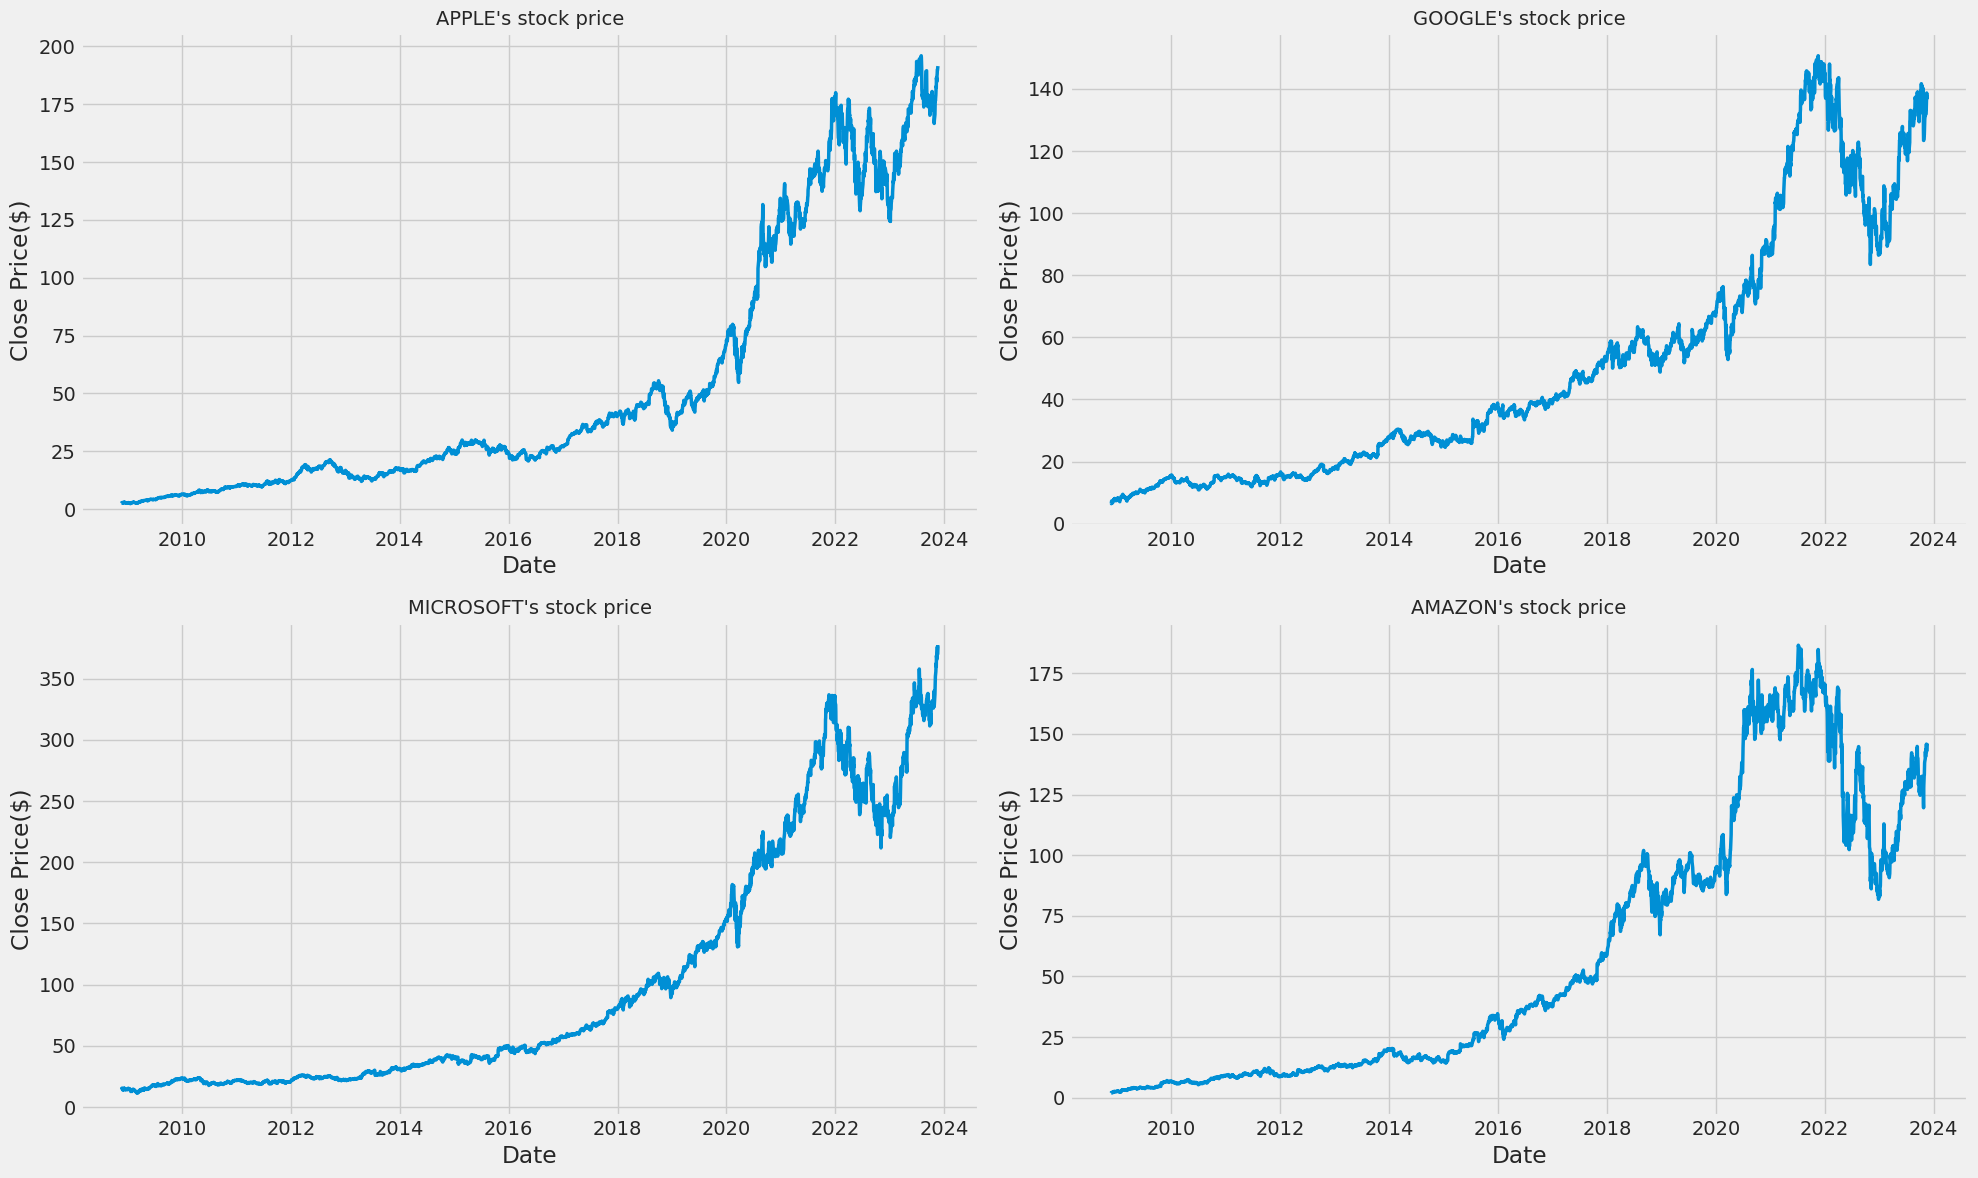

In [9]:
plt.figure(figsize = (20, 12))
plt.subplots_adjust(top=1.25, bottom=1.2)
idx = 0

for name in company_name:
    idx += 1
    plt.subplot(2,2,idx)
    sns.lineplot(stock_data[name]['Adj Close'], linewidth = 2.5)
    plt.xlabel('Date')
    plt.ylabel('Close Price($)')
    plt.title(f"{name}'s stock price", fontsize = 14)

plt.tight_layout()

### The volume of transaction over the period

Volume is a crucial aspect of stock trading as it indicates the level of activity or interest in a particular stock. It represents the total number of shares traded during a specific period, usually a day or a week. Higher volume suggests that more investors are buying and selling the stock, which can lead to significant price movements.<br> <br>
Volume is the lifeblood of any stock. It represents the interest in the trading activity of said shares. Heavier volume indicates heavier interest and vice versa or lighter volume.
<br> <br>
A rise in volume tends to kick off significant price moves in many cases, however it is not a requirement. Despite conventional thinking, breakouts or breakdowns don’t always require heavy volume especially in this age of algorithms that know precisely what price levels will efficiently trigger significant movement. Many traders have gone bust shorting ‘light’ volume breakouts that continue to grind higher despite the lack of sustained heavy volume.

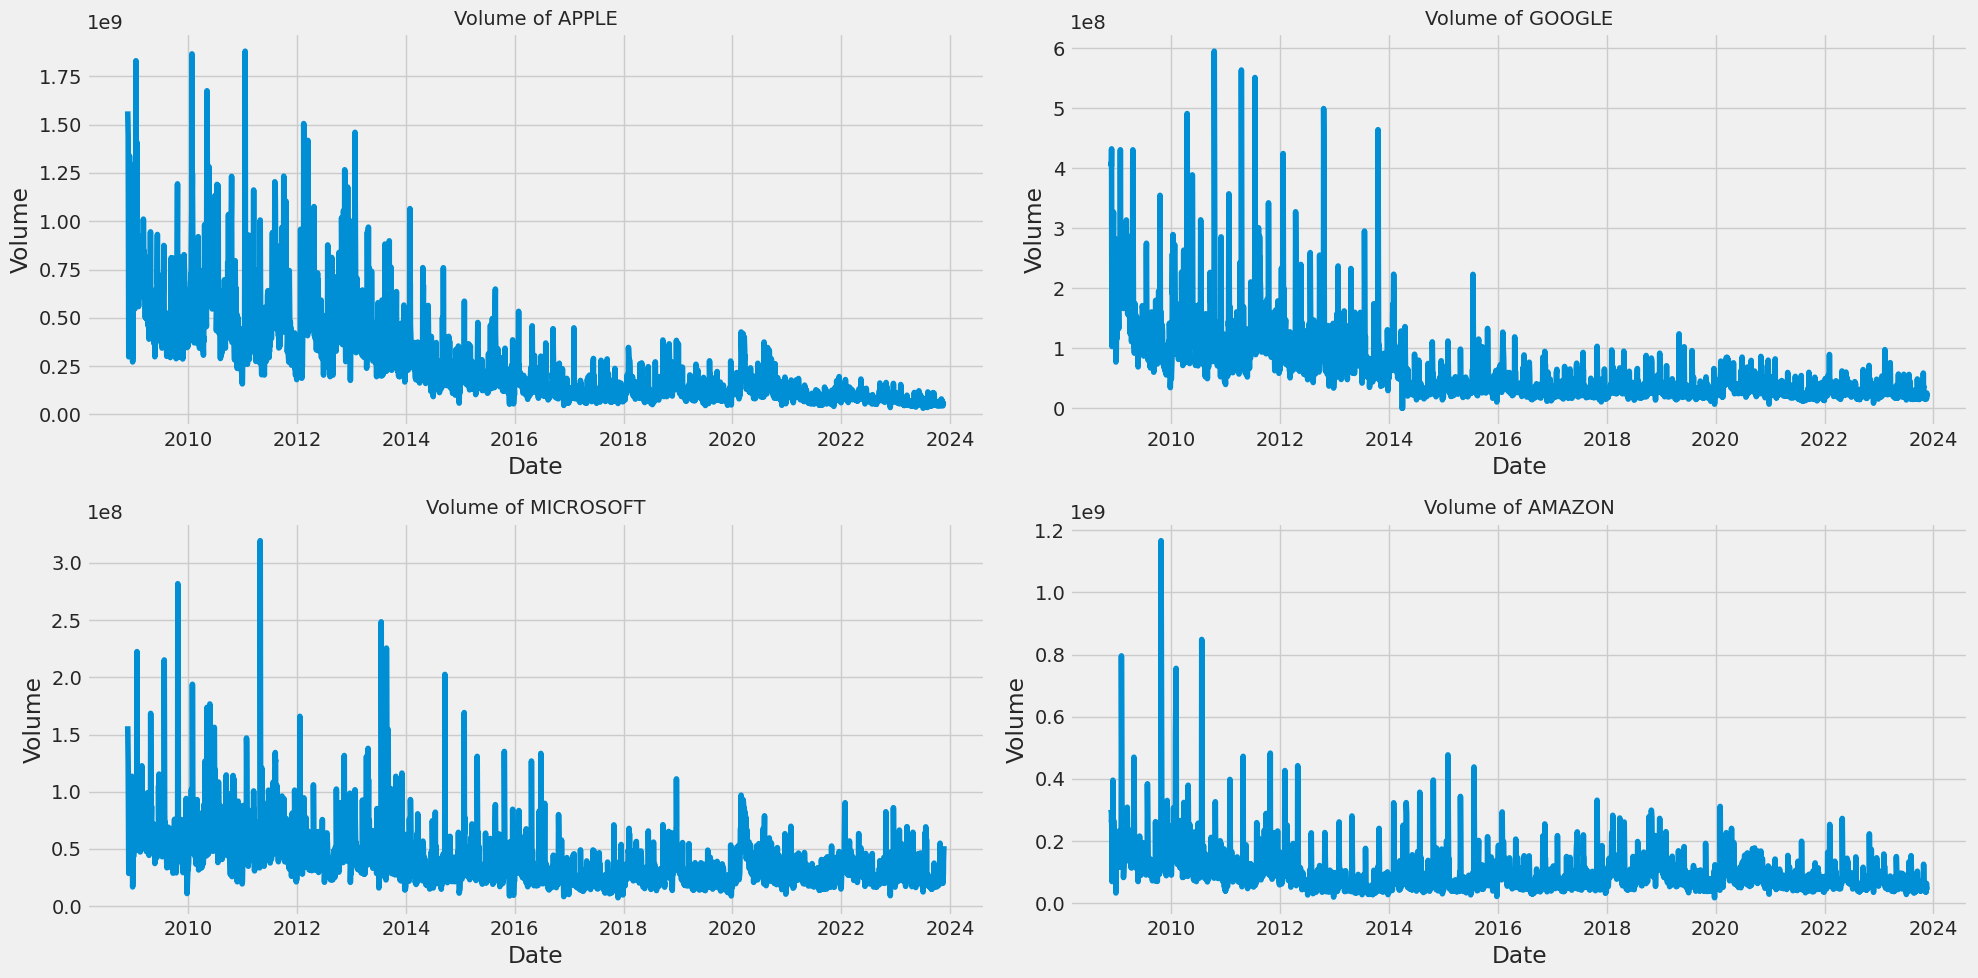

In [10]:
plt.figure(figsize = (20,10))
idx = 0

for name in company_name:
    idx += 1
    plt.subplot(2,2,idx)
    sns.lineplot(stock_data[name]['Volume'])
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.title(f"Volume of {name}", fontsize = 14)

plt.tight_layout()
    

### Show the Simple Moving Average(MA) of all the stock over the time with 2 most use MA index in stock trading: MA50 and MA200 


A simple moving average (SMA) is a technical indicator that is commonly used in stock trading to identify trend direction, support and resistance levels, and potential trading signals. It is a lagging indicator, which means that it is based on past prices. However, it can still be a useful tool for identifying trends and making trading decisions. <br>
<br>How to use SMAs in stock trading:
<br> <br>
-> Identifying trend direction: A rising SMA indicates that a security is in an uptrend, while a falling SMA indicates that a security is in a downtrend.
<br>-> Determining support and resistance levels: SMAs can also be used to determine support and resistance levels. Support is a level where a security is more likely to find buyers, and resistance is a level where a security is more likely to find sellers.
<br>-> Potential trading signals: SMAs can also be used to generate potential trading signals. For example, a trader might look for a buy signal when a price crosses above an SMA, or a sell signal when a price crosses below an SMA.

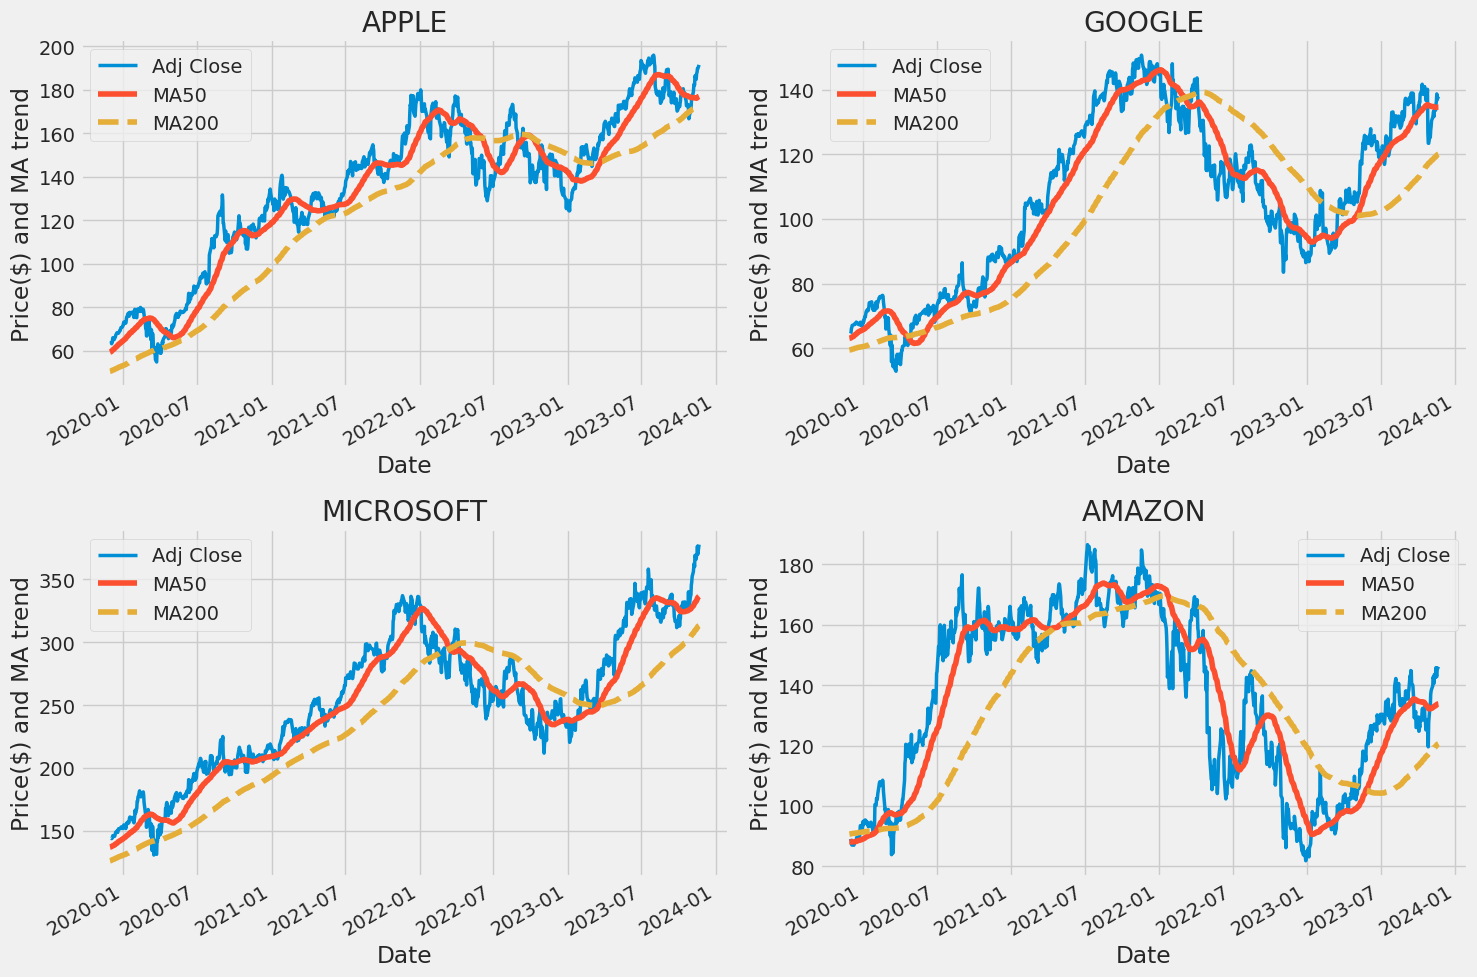

In [11]:
ma_day = [50, 200]

plt.figure(figsize = (15, 10))
idx = 0

for name in company_name:
    idx += 1
    plt.subplot(2, 2, idx)
    stock_data[name]['Adj Close'][-1000:].plot(linewidth = 2.5)
    stock_data[name]['Adj Close'][-1000 - ma_day[0]:].rolling(ma_day[0]).mean().plot()
    stock_data[name]['Adj Close'][-1000 - ma_day[1]:].rolling(ma_day[1]).mean().plot(style = '--')
    plt.xlabel('Date')
    plt.ylabel('Price($) and MA trend')
    plt.title(f'{name}')
    plt.legend(['Adj Close', 'MA50', 'MA200'])

plt.tight_layout()

### Daily Return of each stock

The daily return of a stock is a key metric that investors use to assess the performance of individual stocks and the overall market. It is calculated by subtracting the opening price of a stock from the closing price and dividing by the opening price. The result is expressed as a percentage.

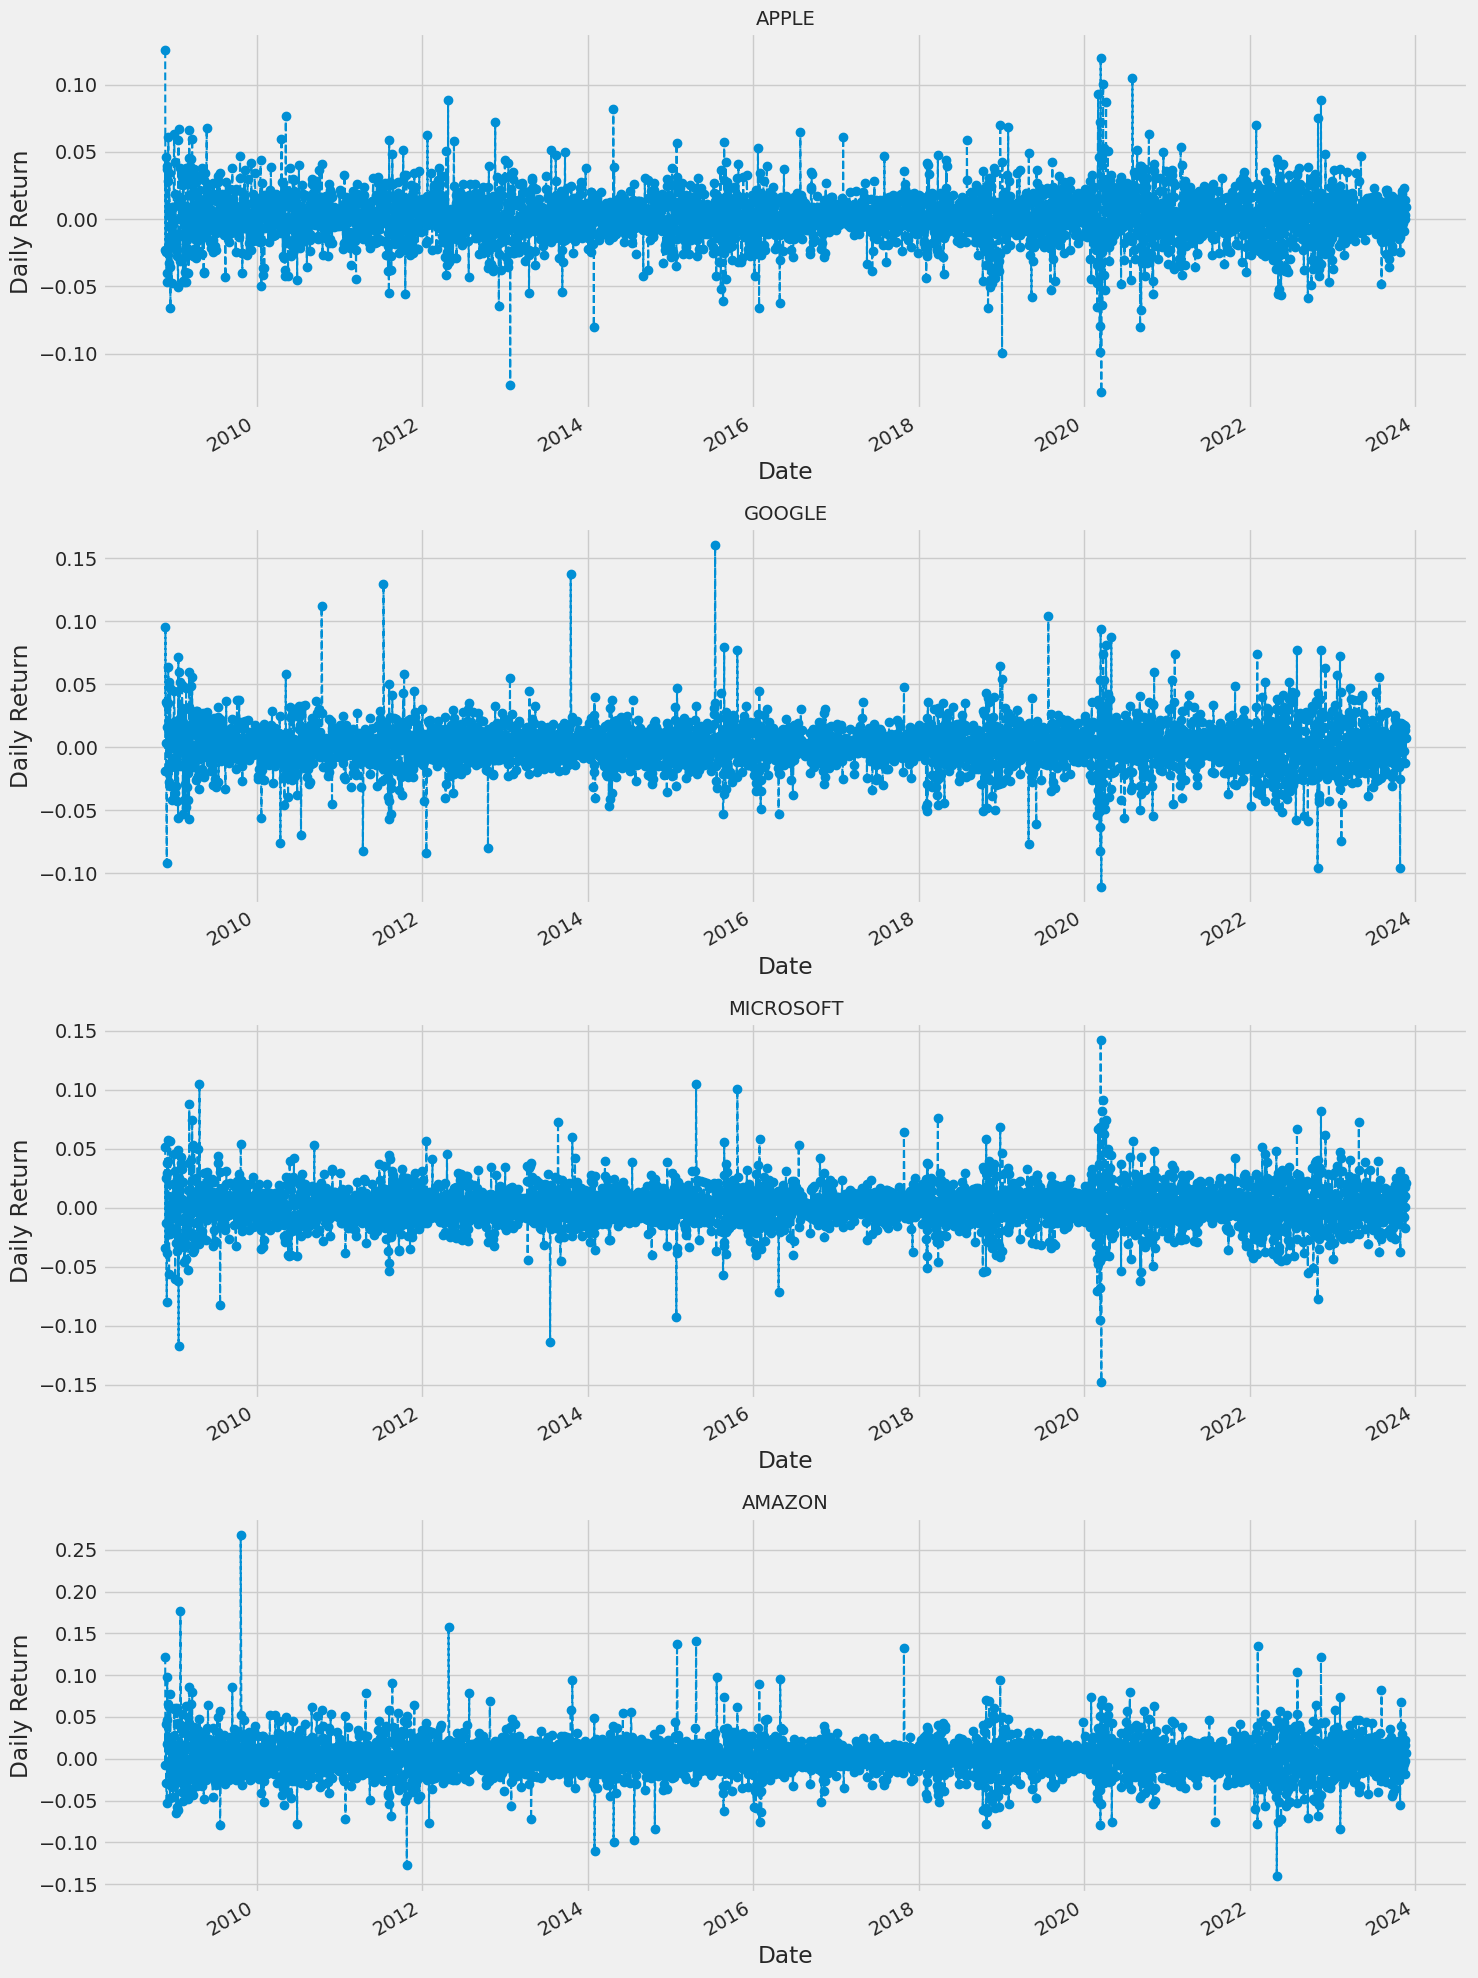

In [12]:
plt.figure(figsize = (15,20))
idx = 0

for name in company_name:
    idx += 1
    plt.subplot(4,1,idx)
    stock_data[name]['Adj Close'].pct_change().plot(linestyle = '--', marker = 'o', linewidth = 1.5)
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title(f"{name}", fontsize = 14)

plt.tight_layout()

# Candlestick Plotting

The Candlestick Plotting, also known as Japanese candlestick chart, is a type of financial chart used to depict the price movement of a security over a specific period of time. It is a popular chart type used by traders and investors to analyze price trends and make trading decisions.<br>
<br>
Each candlestick represents one period of time, such as one day, one week, or one month. The candlestick has four key components: 
<br>
<br>
Open: The opening price of the security for that period.<br>
High: The highest price the security traded at during that period.<br>
Low: The lowest price the security traded at during that period.<br>
Close: The closing price of the security for that period.<br>



[*********************100%%**********************]  1 of 1 completed


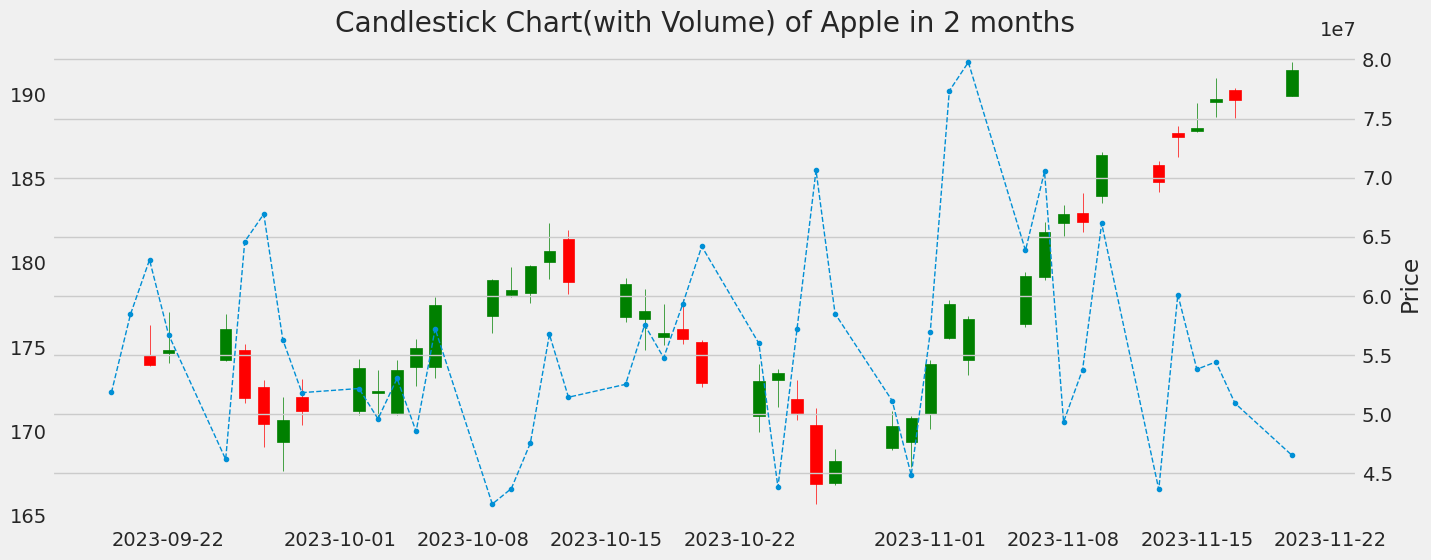

In [13]:
# Candlestick Chart
# Extract a shorter dataset to plot in more details 
end_date = datetime.now()
start_date = datetime(end_date.year, end_date.month - 2, end_date.day)
temp_df = pdr.get_data_yahoo('AAPL', start = start_date, end = end_date)

# Create an array of tuples in the required format
ohlc = np.vstack((mdates.date2num(temp_df.index), temp_df['Open'], temp_df['High'], 
                  temp_df['Low'], temp_df['Close'])).T

plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

ax1 = ax.twinx()
ax1.plot(stock_data['APPLE'][len(date_time) - 45:]['Volume'], linestyle = '--', marker = '.', linewidth = 1.0)
ax.xaxis_date()
ax.grid(False)
plt.title('Candlestick Chart(with Volume) of Apple in 2 months')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## General Plot of Stock's index 

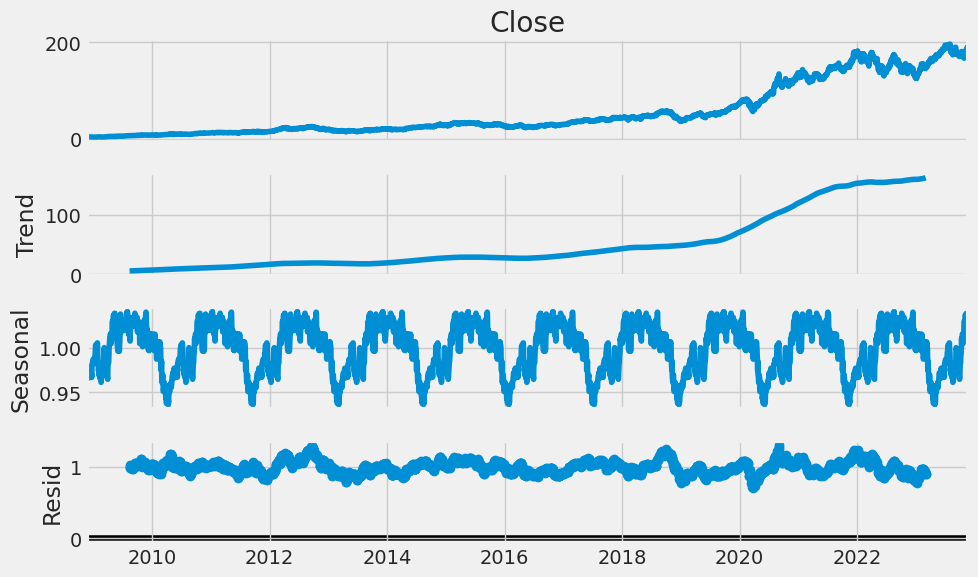

In [14]:
result = seasonal_decompose(stock_data['APPLE']['Close'].dropna(), model='multiplicative', period=365)
result.plot()
plt.show()

## Data Preparation and Prediciton

In [15]:
# Preprocessing for the data
train_size = 0.9
train_data_len = int(np.ceil(AAPL.shape[0] * train_size))
pre_days = 90

def preprocessing(df):

    # Get only the 'Close' price from thae data
    data = df.filter(['Close'])
    dataset = data.values

    # Data Scaler
    global scaler
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    # Train/Test Split
    train_data = scaled_data[0:int(train_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(pre_days, len(train_data)):
        x_train.append(train_data[i - pre_days:i, 0])
        y_train.append(train_data[i, 0])
            
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Create a new array containing scaled values
    test_data = scaled_data[train_data_len - pre_days: , :]

    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[train_data_len:, :]
    for i in range(pre_days, len(test_data)):
        x_test.append(test_data[i - pre_days:i, 0])
        
    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
        
    return x_train, y_train, x_test, y_test




### For Apple Stock

## LSTM Model

In [16]:
# Apple preprocessing
AAPL_train_x, AAPL_train_y, AAPL_test_x, AAPL_test_y = preprocessing(AAPL)[0], preprocessing(AAPL)[1], preprocessing(AAPL)[2], preprocessing(AAPL)[3]
AAPL_train_x.shape, AAPL_train_y.shape, AAPL_test_x.shape, AAPL_test_y.shape

((3307, 90, 1), (3307,), (377, 90, 1), (377, 1))

In [17]:
# Build the LSTM model
model_aapl = Sequential()
model_aapl.add(LSTM(128, return_sequences = True, input_shape = (AAPL_train_x.shape[1], 1)))
model_aapl.add(LSTM(64, return_sequences = True))
model_aapl.add(LSTM(32, return_sequences = False))
model_aapl.add(Dense(62))
model_aapl.add(Dense(16))
model_aapl.add(Dense(1))

# Compile the model
model_aapl.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_aapl.fit(AAPL_train_x, AAPL_train_y, batch_size = 1, epochs = 10)

# Get the models predicted price values 
predictions = model_aapl.predict(AAPL_test_x)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(AAPL_test_y, predictions))
rmse

Epoch 1/10
3307/3307 [==============================] - 47s 11ms/step - loss: 0.0014
Epoch 2/10
3307/3307 [==============================] - 37s 11ms/step - loss: 6.8802e-04
Epoch 3/10
3307/3307 [==============================] - 37s 11ms/step - loss: 4.7798e-04
Epoch 4/10
3307/3307 [==============================] - 37s 11ms/step - loss: 2.7702e-04
Epoch 5/10
3307/3307 [==============================] - 37s 11ms/step - loss: 3.0610e-04
Epoch 6/10
3307/3307 [==============================] - 37s 11ms/step - loss: 1.8776e-04
Epoch 7/10
3307/3307 [==============================] - 37s 11ms/step - loss: 2.1243e-04
Epoch 8/10
3307/3307 [==============================] - 37s 11ms/step - loss: 1.9299e-04
Epoch 9/10
3307/3307 [==============================] - 37s 11ms/step - loss: 1.6653e-04
Epoch 10/10
12/12 [==============================] - 1s 7ms/step


4.945055341610107

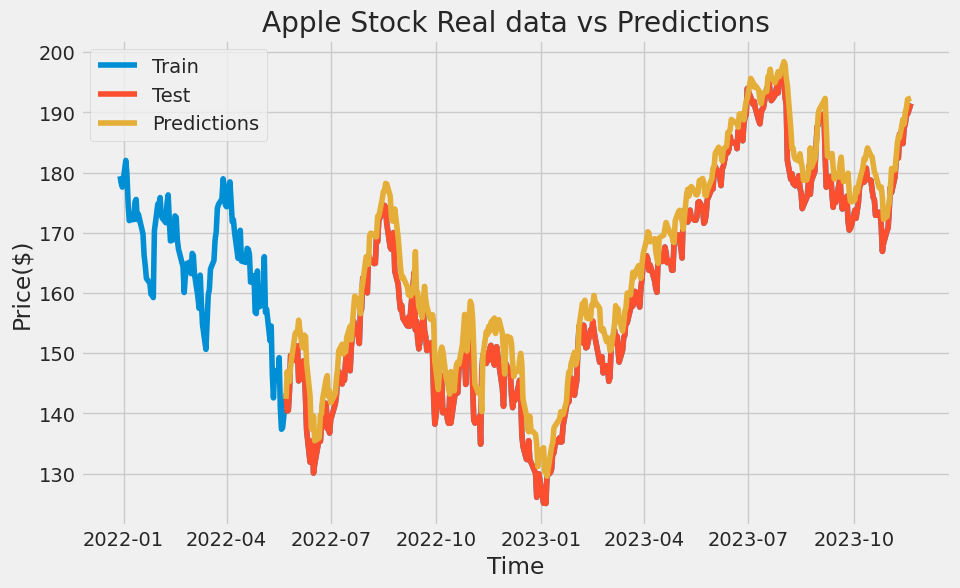

In [18]:
# Plot the test data and predictions
pre_test = AAPL[train_data_len - 100:]
test = AAPL[train_data_len:]
test['Prediction'] = predictions

plt.figure(figsize = (10,6))
plt.plot(pre_test['Close'])
plt.plot(test[['Close', 'Prediction']])
plt.xlabel('Time')
plt.ylabel('Price($)')
plt.title('Apple Stock Real data vs Predictions')
plt.legend(['Train','Test', 'Predictions'], loc = 'best')
plt.show()

In [19]:
# Predict the tomorrow Price of Apple

# Get previous data and extract the pre_days of data for model prediction
# today = '2023-10-26'
today = datetime.now()
start = '2023-05-01'
AAPL_today = pdr.get_data_yahoo('AAPL', start = start, end = today)
close = AAPL_today[AAPL_today.shape[0] - pre_days :]['Close'].values
close = np.array(close)
close = scaler.transform(np.reshape(close, (close.shape[0], 1)))
close = np.reshape(close, (1, close.shape[0], 1))

# The Prediction for AAPL today stock price
print(f'The prediction for AAPL stock price today {scaler.inverse_transform(model_aapl.predict(close))[0][0]}')

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 24ms/step
The prediction for AAPL stock price today 193.76776123046875


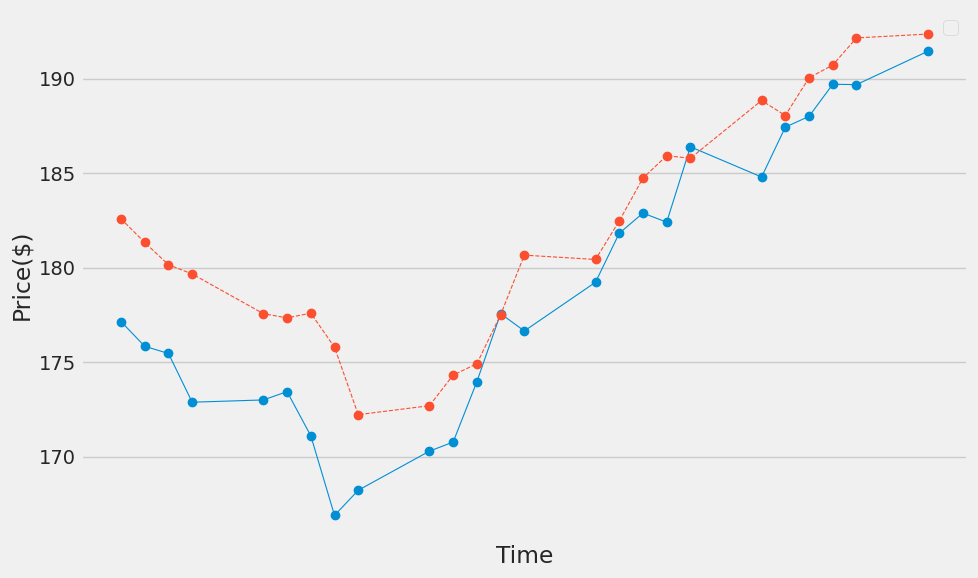

In [20]:
plt.figure(figsize = (10,6))
# plt.plot(pre_test['Close'])
plt.plot(test['Close'][-25:], marker = 'o', linewidth = 0.8)
plt.plot(test['Prediction'][-25:], linestyle = '--', marker = 'o', linewidth = 0.8)
plt.xlabel('Time')
plt.ylabel('Price($)')
plt.xticks([])
plt.legend()
plt.tight_layout()

### The above model and data is not suitable for predicting the Stock Price because of the input and output is the same and through the plot of the result, we can conclude that the model just only mimic the transaction result of the previous day and have the weight of the day too large and the trend of the stock is almost always 1-day later than the truth! Therefore this model of prediction is not good for stock prediction

## ARIMA Forecasting model

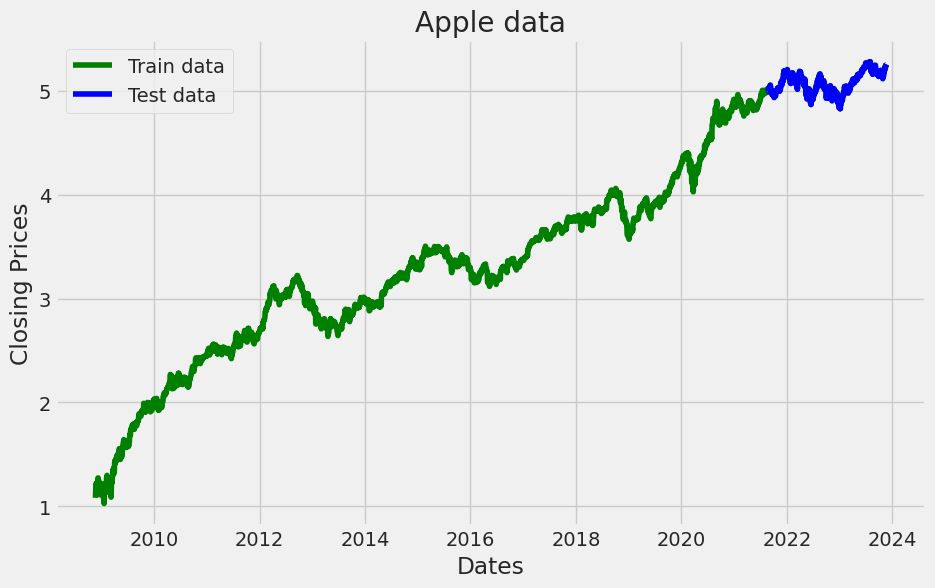

In [21]:
def arima_data(company_name):
    # Convert the raw data into the log of them to help the model to be more accuracy
    df_log = np.log(stock_data[company_name]['Close'])

    #split data into train and training set
    train_data, test_data = df_log[3:int(len(df_log)*0.85)], df_log[int(len(df_log)*0.85):]
    return df_log, train_data, test_data

aapl_log, aapl_train, aapl_test = arima_data('APPLE')
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(aapl_log, 'green', label='Train data')
plt.plot(aapl_test, 'blue', label='Test data')
plt.title('Apple data')
plt.legend()

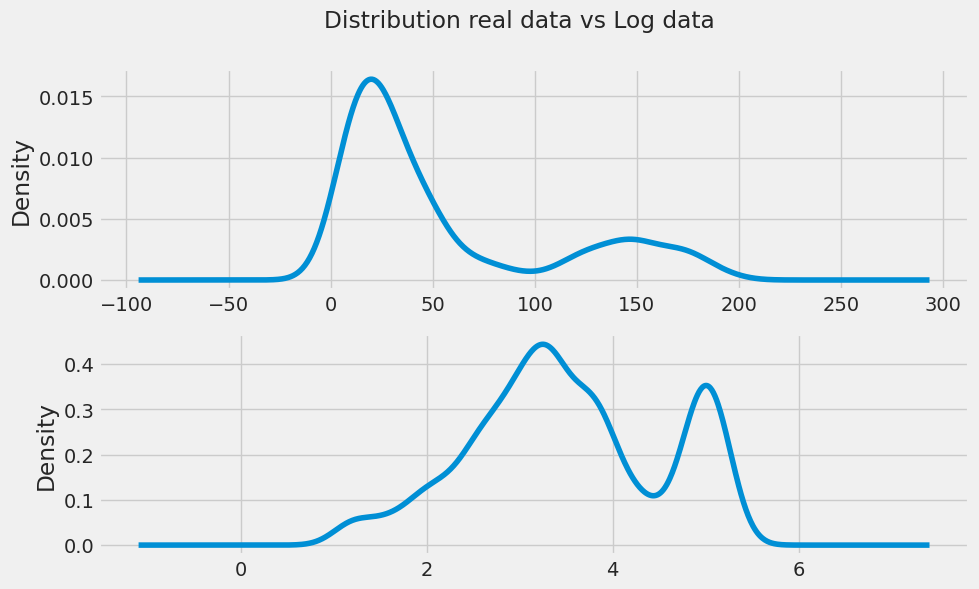

In [22]:
fig, axs = plt.subplots(2)
fig.suptitle('Distribution real data vs Log data')
stock_data['APPLE']['Close'].plot(kind = 'kde', ax = axs[0])
aapl_log.plot(kind = 'kde', ax = axs[1])
plt.show()

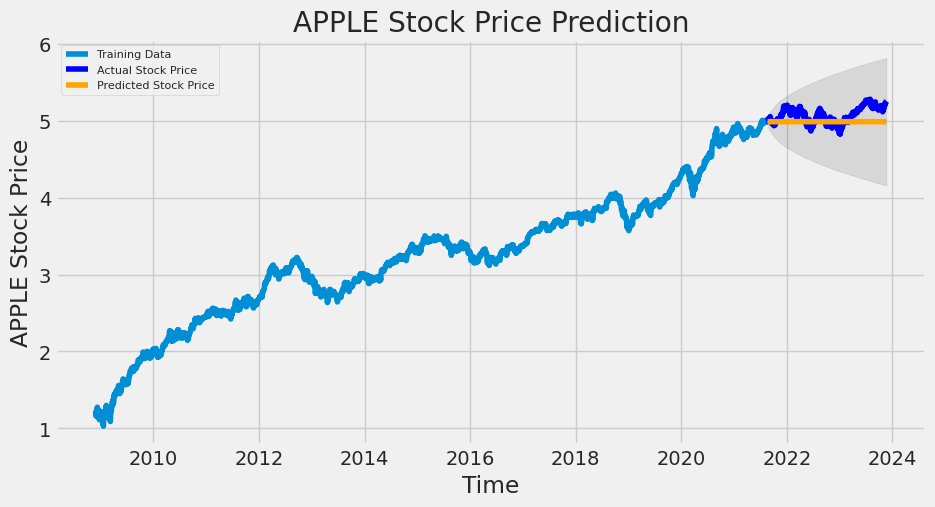

In [23]:
model = ARIMA(aapl_train, order=(1,1,3))  
model_fit = model.fit() 
fc = model_fit.get_forecast(steps = 567, alpha = 0.2)
fc1 = fc.predicted_mean
conf = fc.conf_int()

# Make as pandas series
fc_series = pd.Series(fc1.values, index = aapl_test.index)
lower_series = pd.Series(conf['lower Close'].values, index = aapl_test.index)
upper_series = pd.Series(conf['upper Close'].values, index = aapl_test.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(aapl_train, label = 'Training Data')
plt.plot(aapl_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(fc_series, color = 'orange', label = 'Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()